In [1]:
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
import astropy.coordinates as coord

%matplotlib inline
plt.style.use('/jet/home/tvnguyen/mplstyle/default.mplstyle')

In [2]:
catalog_root = '/ocean/projects/phy210068p/shared/gaia_catalogs/'
catalog_name = 'GaiaDR3_reduced_v1'
labels_name = 'GaiaDR3_reduced_v0'
features = ('ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity')
plotdir = '/jet/home/tvnguyen/accreted_catalog/gaia_accreted_catalog/notebooks/figures'
os.makedirs(plotdir, exist_ok=True)

catalog = {k: [] for k in features}
catalog['score'] = []
catalog['index'] = []
for i in range(10):
    data_path = os.path.join(catalog_root, catalog_name, f'data.{i}.hdf5')
    labels_path = os.path.join(catalog_root, labels_name, f'labels.{i}.hdf5')
    print(f'Loading data from {data_path} and {labels_path}')

    with h5py.File(labels_path, 'r') as f:
        score = f['score'][:]
        label_source_id = f['source_id'][:]
        index = f['index'][:]
    catalog['score'].append(score)
    catalog['index'].append(index)

    with h5py.File(data_path, 'r') as f:
        for k in features:
            catalog[k].append(f[k][:][index])  # not f[k][index] because it is slower for some reason

for key in catalog:
    catalog[key] = np.concatenate(catalog[key], axis=0)

Loading data from /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_reduced_v1/data.0.hdf5 and /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_reduced_v0/labels.0.hdf5
Loading data from /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_reduced_v1/data.1.hdf5 and /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_reduced_v0/labels.1.hdf5
Loading data from /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_reduced_v1/data.2.hdf5 and /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_reduced_v0/labels.2.hdf5
Loading data from /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_reduced_v1/data.3.hdf5 and /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_reduced_v0/labels.3.hdf5
Loading data from /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_reduced_v1/data.4.hdf5 and /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_reduced_v0/labels.4.hdf5
Loading data from /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_reduced_v1/data.

In [3]:
# convert from RA, Dec, parallax, pmra, pmdec, radial_velocity to Galactocentric coordinates
distance = coord.Distance(parallax=catalog['parallax']*u.mas).to(u.kpc)
c = coord.SkyCoord(
    ra=catalog['ra']*u.deg, dec=catalog['dec']*u.deg,
    pm_ra_cosdec=catalog['pmra']*u.mas/u.yr, pm_dec=catalog['pmdec']*u.mas/u.yr,
    radial_velocity=catalog['radial_velocity']*u.km/u.s,
    distance=distance,
    frame='icrs'
)
galcen = c.transform_to(coord.Galactocentric)

In [4]:
def convert_to_cylindrical_velocity(x, y, z, vx, vy, vz):
    """ return R, phi, z, vR, vT, vz """
    R = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    vR = (x*vx + y*vy)/R
    vT = (x*vy - y*vx)/R
    return R, phi, z, vR, vT, vz

x = galcen.x.to(u.kpc).value
y = galcen.y.to(u.kpc).value
z = galcen.z.to(u.kpc).value
vx = galcen.v_x.to(u.km/u.s).value
vy = galcen.v_y.to(u.km/u.s).value
vz = galcen.v_z.to(u.km/u.s).value
R, phi, z, vR, vT, vz = convert_to_cylindrical_velocity(x, y, z, vx, vy, vz)

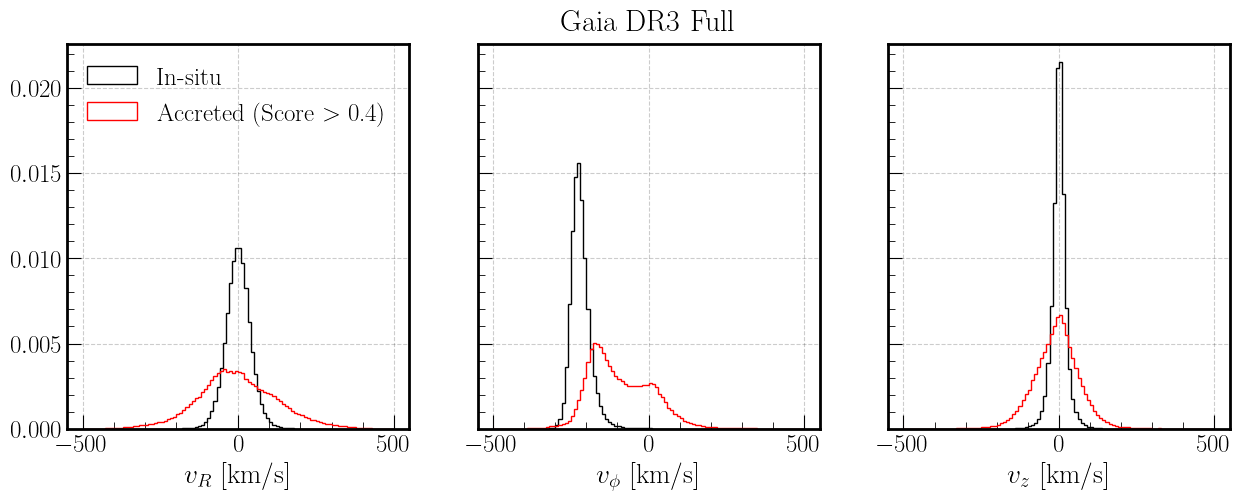

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

threshold = 0.4
score = catalog['score']
label = score > threshold
plot_range = (-500, 500)
bins = 100

axes[0].hist(
    vR[~label], bins=bins, range=plot_range, density=True,
    histtype='step', color='k', label='In-situ')
axes[0].hist(
    vR[label], bins=bins, range=plot_range, density=True,
    histtype='step', color='r', label=r'Accreted (Score $>$ {:.1f})'.format(threshold))

axes[1].hist(
    vT[~label], bins=bins, range=plot_range, density=True,
    histtype='step', color='k', label='In-situ')
axes[1].hist(
    vT[label], bins=bins, range=plot_range, density=True,
    histtype='step', color='r', label='Accreted')

axes[2].hist(
    vz[~label], bins=bins, range=plot_range, density=True,
    histtype='step', color='k', label='In-situ')
axes[2].hist(
    vz[label], bins=bins, range=plot_range, density=True,
    histtype='step', color='r', label='Accreted')

axes[0].set_xlabel(r'$v_R$ [km/s]')
axes[1].set_xlabel(r'$v_\phi$ [km/s]')
axes[2].set_xlabel(r'$v_z$ [km/s]')
axes[0].legend()
axes[1].set_title('Gaia DR3 Full')

plt.show()
fig.savefig(
    os.path.join(plotdir, f'vdist_gaia_dr3_full_{threshold:.2f}.png'), dpi=300, 
    bbox_inches='tight')

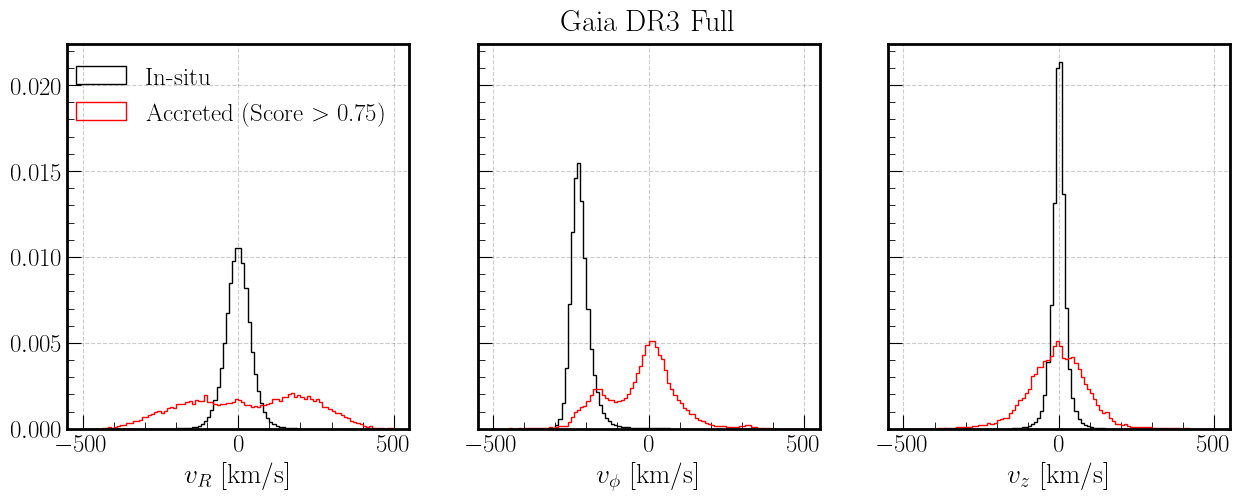

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

threshold = 0.75
score = catalog['score']
label = score > threshold
plot_range = (-500, 500)
bins = 100

axes[0].hist(
    vR[~label], bins=bins, range=plot_range, density=True,
    histtype='step', color='k', label='In-situ')
axes[0].hist(
    vR[label], bins=bins, range=plot_range, density=True,
    histtype='step', color='r', label=r'Accreted (Score $>$ {:.2f})'.format(threshold))

axes[1].hist(
    vT[~label], bins=bins, range=plot_range, density=True,
    histtype='step', color='k', label='In-situ')
axes[1].hist(
    vT[label], bins=bins, range=plot_range, density=True,
    histtype='step', color='r', label='Accreted')

axes[2].hist(
    vz[~label], bins=bins, range=plot_range, density=True,
    histtype='step', color='k', label='In-situ')
axes[2].hist(
    vz[label], bins=bins, range=plot_range, density=True,
    histtype='step', color='r', label='Accreted')

axes[0].set_xlabel(r'$v_R$ [km/s]')
axes[1].set_xlabel(r'$v_\phi$ [km/s]')
axes[2].set_xlabel(r'$v_z$ [km/s]')
axes[0].legend()
axes[1].set_title('Gaia DR3 Full')

plt.show()
fig.savefig(
    os.path.join(plotdir, f'vdist_gaia_dr3_full_{threshold:.2f}.png'), dpi=300, 
    bbox_inches='tight')

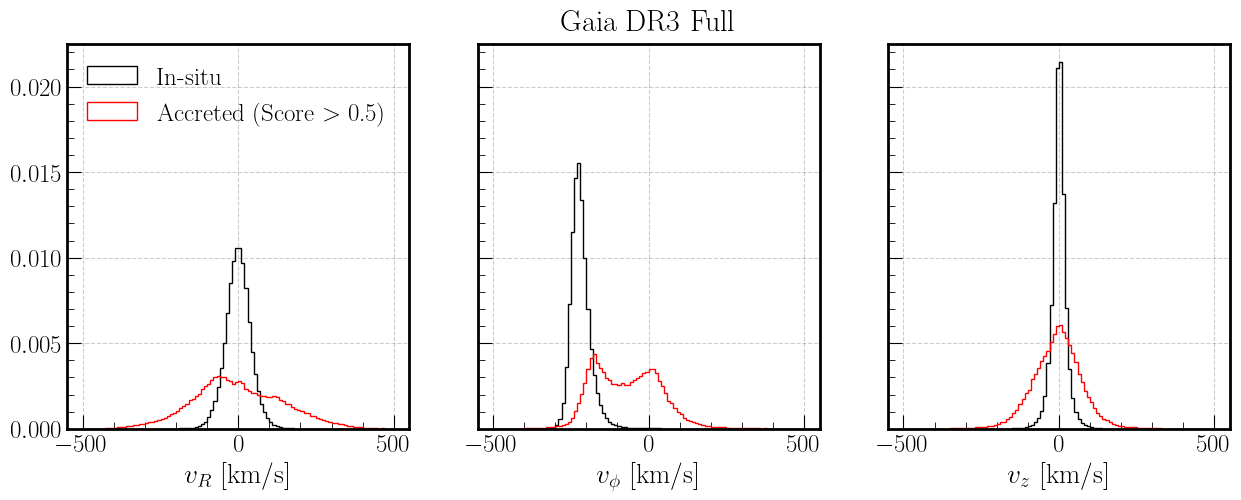

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

threshold = 0.5
score = catalog['score']
label = score > threshold
plot_range = (-500, 500)
bins = 100

axes[0].hist(
    vR[~label], bins=bins, range=plot_range, density=True,
    histtype='step', color='k', label='In-situ')
axes[0].hist(
    vR[label], bins=bins, range=plot_range, density=True,
    histtype='step', color='r', label=r'Accreted (Score $>$ {:.1f})'.format(threshold))

axes[1].hist(
    vT[~label], bins=bins, range=plot_range, density=True,
    histtype='step', color='k', label='In-situ')
axes[1].hist(
    vT[label], bins=bins, range=plot_range, density=True,
    histtype='step', color='r', label='Accreted')

axes[2].hist(
    vz[~label], bins=bins, range=plot_range, density=True,
    histtype='step', color='k', label='In-situ')
axes[2].hist(
    vz[label], bins=bins, range=plot_range, density=True,
    histtype='step', color='r', label='Accreted')

axes[0].set_xlabel(r'$v_R$ [km/s]')
axes[1].set_xlabel(r'$v_\phi$ [km/s]')
axes[2].set_xlabel(r'$v_z$ [km/s]')
axes[0].legend()
axes[1].set_title('Gaia DR3 Full')

plt.show()
fig.savefig(
    os.path.join(plotdir, f'vdist_gaia_dr3_full_{threshold:.2f}.png'), dpi=300, 
    bbox_inches='tight')